In [1]:
from sklearn.model_selection import train_test_split
import sqlite3
import numpy as np
import keras
from keras.utils import to_categorical
import pandas as pd
from PIL import Image
import io
import pickle

def load_dataset(database_path):
     # Connect to the SQLite database
    conn = sqlite3.connect('lfw_dataset.db')

    # Query to select all records from the faces table
    query = "SELECT * FROM faces"

    # Fetch records from the database into a Pandas DataFrame
    df = pd.read_sql_query(query, conn)
    df['image'] = df['image'].apply(lambda x: np.array(pickle.loads(x)))
    # Close the database connection
    conn.close()
    # Convert image bytes to numpy array
    num_classes = len(np.unique(df['target']))
    return df, num_classes

2023-11-27 19:58:59.202972: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def split_dataset(df, test_size=0.2, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(df['image'].values, df['target'].values, test_size=test_size, random_state=random_state)
    # Convert the image arrays to a numpy array
    X_train = np.array([np.array(img) for img in X_train])
    X_test = np.array([np.array(img) for img in X_test])
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Print the shapes of the resulting sets
    print("Training set shape:", X_train.shape, y_train.shape)
    print("Testing set shape:", X_test.shape, y_test.shape)

    # Plot the first image in X_train
    plt.imshow(X_train[0])
    plt.title('First Image in X_train')
    plt.show()

    return X_train, X_test, y_train, y_test

In [3]:

def preprocess_and_print_shapes(y_train, y_test):
    y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
    y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

    print("Training set shape:", X_train.shape, y_train.shape)
    print("Testing set shape:", X_test.shape, y_test.shape)

    return y_train_categorical, y_test_categorical

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def train_cnn_model(input_shape, num_classes, X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=10)
    return model


In [5]:
def get_accuracy(model):
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test accuracy:', score[1])

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(df, model, X_test, y_test, num_rows=5, num_cols=5, figsize=(20, 20)):
    # Make predictions on the test set
    predicted_probabilities = model.predict(X_test)
    predicted_classes = np.argmax(predicted_probabilities, axis=1)

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.ravel()

    # Loop through the test set and visualize predictions
    for i in range(num_rows * num_cols):
        
        actual_name = df['name'][np.where(df['target'].values == np.argmax(y_test, axis=1)[i])[0][0]]
        predicted_name = df['name'][np.where(df['target'].values == predicted_classes[i])[0][0]] 

        axes[i].imshow(X_test[i])
        axes[i].set_title("Prediction Class = {}\nTrue Class = {}".format(predicted_name, actual_name))
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()


<class 'numpy.ndarray'>
Training set shape: (2418, 62, 47, 3) (2418,)
Testing set shape: (605, 62, 47, 3) (605,)


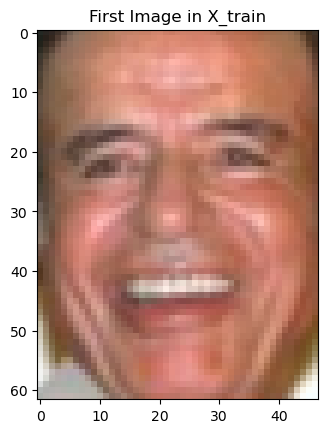

Training set shape: (2418, 62, 47, 3) (2418,)
Testing set shape: (605, 62, 47, 3) (605,)
Epoch 1/10
242/242 [==============================] - 9s 29ms/step - loss: 3.7442 - accuracy: 0.1741 - val_loss: 3.6844 - val_accuracy: 0.1752
Epoch 2/10
242/242 [==============================] - 7s 29ms/step - loss: 3.5711 - accuracy: 0.1811 - val_loss: 3.2564 - val_accuracy: 0.2066
Epoch 3/10
242/242 [==============================] - 6s 27ms/step - loss: 3.0480 - accuracy: 0.2477 - val_loss: 2.8878 - val_accuracy: 0.2843
Epoch 4/10
242/242 [==============================] - 7s 27ms/step - loss: 2.4669 - accuracy: 0.3668 - val_loss: 2.4853 - val_accuracy: 0.3785
Epoch 5/10
242/242 [==============================] - 7s 29ms/step - loss: 1.9289 - accuracy: 0.4859 - val_loss: 1.9333 - val_accuracy: 0.5025
Epoch 6/10
242/242 [==============================] - 7s 29ms/step - loss: 1.4112 - accuracy: 0.6067 - val_loss: 1.6942 - val_accuracy: 0.5504
Epoch 7/10
242/242 [==============================] -

/Users/jenniferhalgh/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 0s 17ms/step


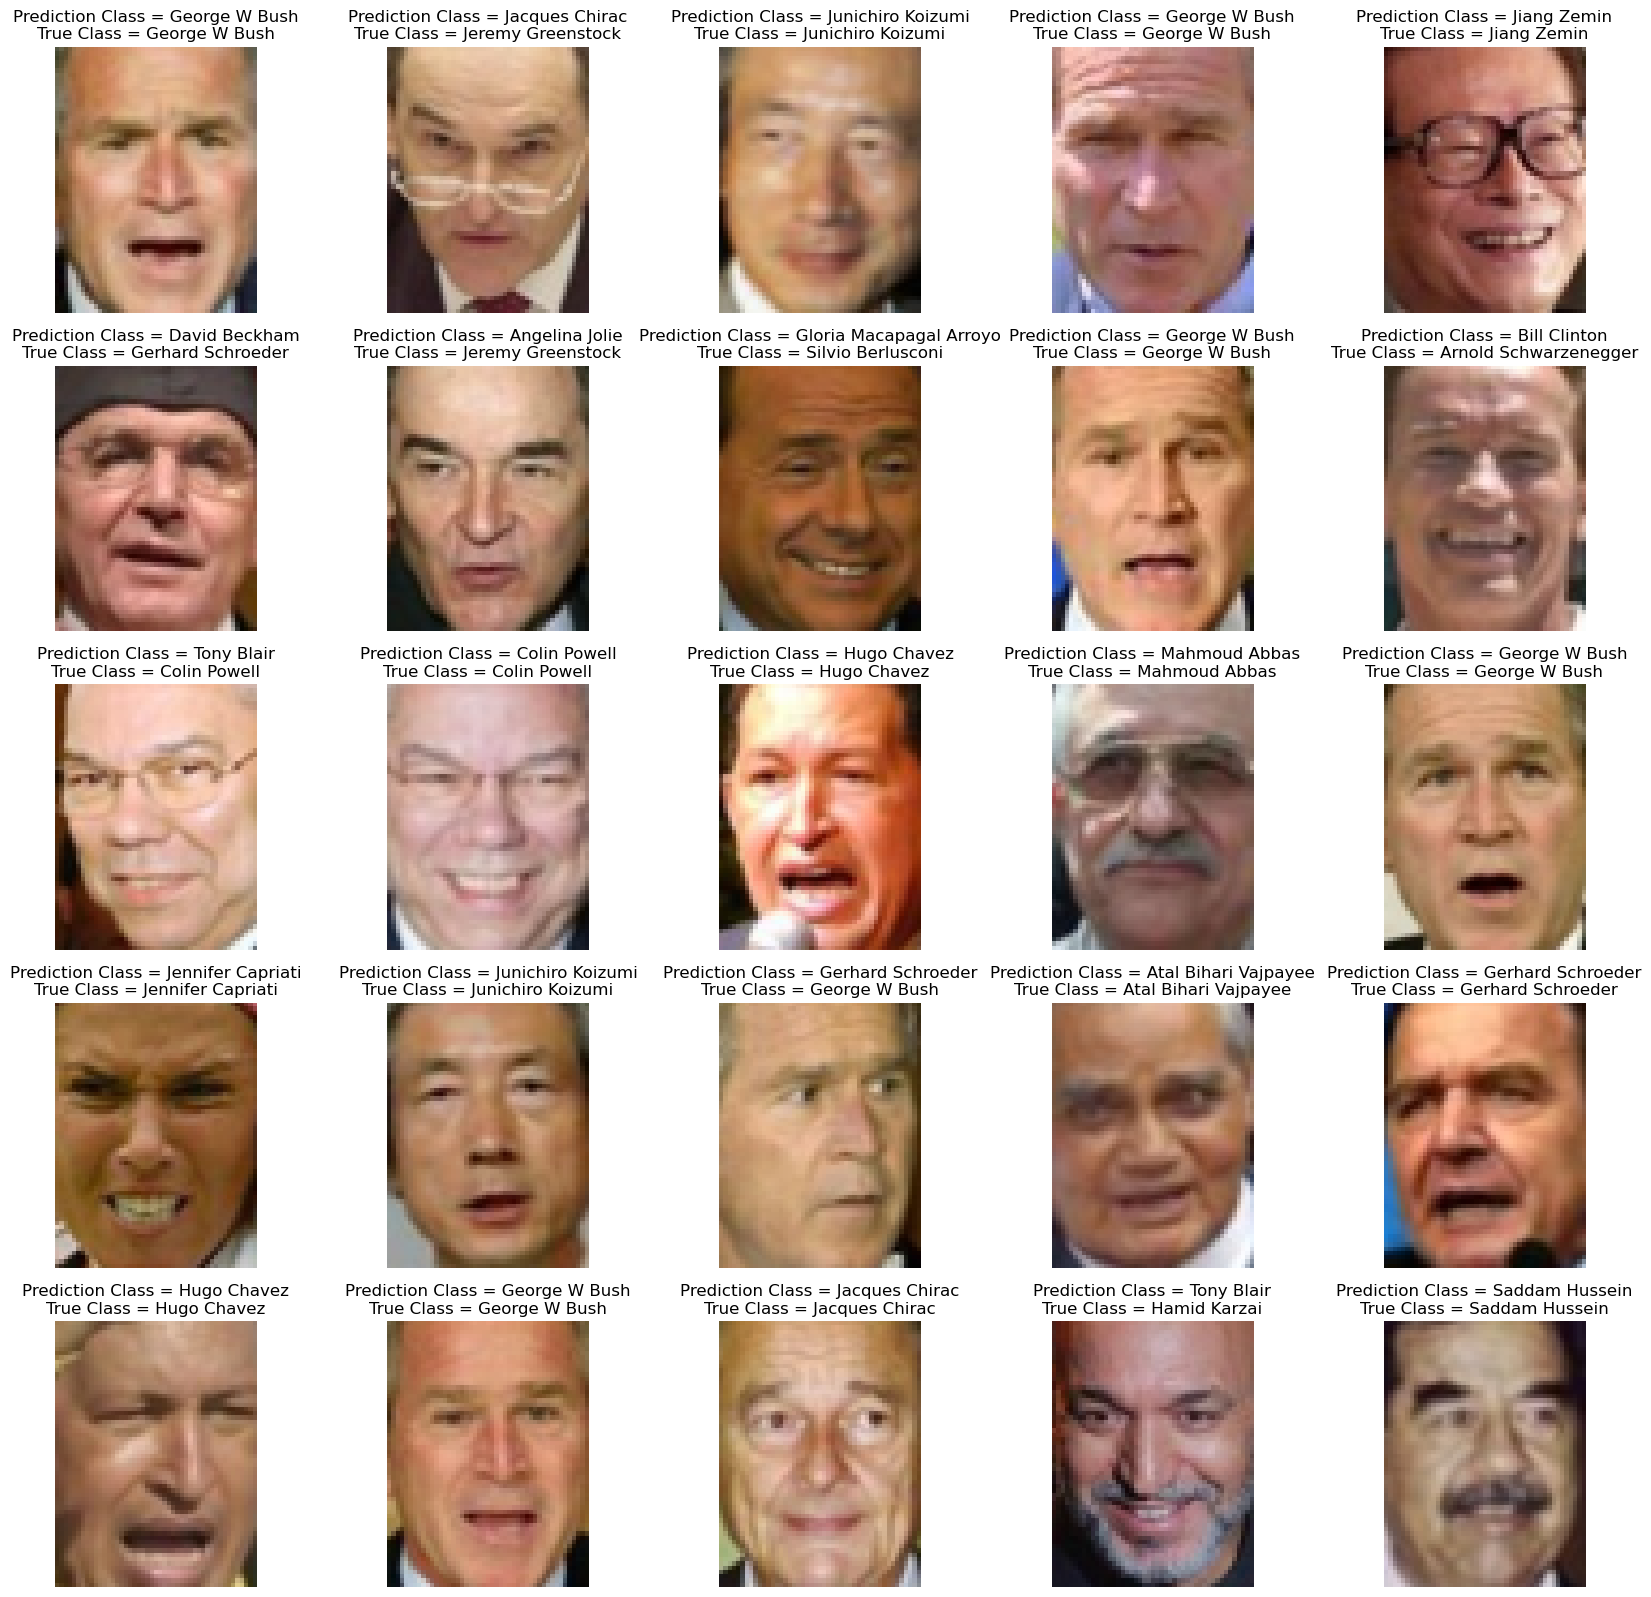

In [7]:
df, num_classes = load_dataset('lfw_dataset.db')
X_train, X_test, y_train, y_test = split_dataset(df)

y_train, y_test = preprocess_and_print_shapes(y_train, y_test)

input_shape = (62, 47, 3)

cnn_model = train_cnn_model(input_shape, num_classes, X_train, y_train, X_test, y_test)
# Train the model
get_accuracy(cnn_model)

# Save the trained model
cnn_model.save('trained_model.h5')

#visualize the model on test set
visualize_predictions(df, cnn_model, X_test, y_test)